Imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig

Step 1: Reading the data

In [2]:
def loadData(csvFile):
    data = np.empty((10000, 12))
    with open(csvFile, "r") as inp:
        rawData = inp.readlines()
        for i in range(0, 10000):
            line = rawData[i]
            row = [float(x) for x in line.split(",")]
            data[i] = np.array(row)
    return(np.transpose(data))

In [3]:
inputData = loadData('sampleECG.csv')

def getLeadData(lead):
    return inputData[lead]

Step 2: Plotting the data

In [4]:
def plotSignal(signal, title):
    plt.figure(figsize=(20, 2))
    plt.plot(signal, linewidth=0.5)
    plt.title(title)
    plt.show()

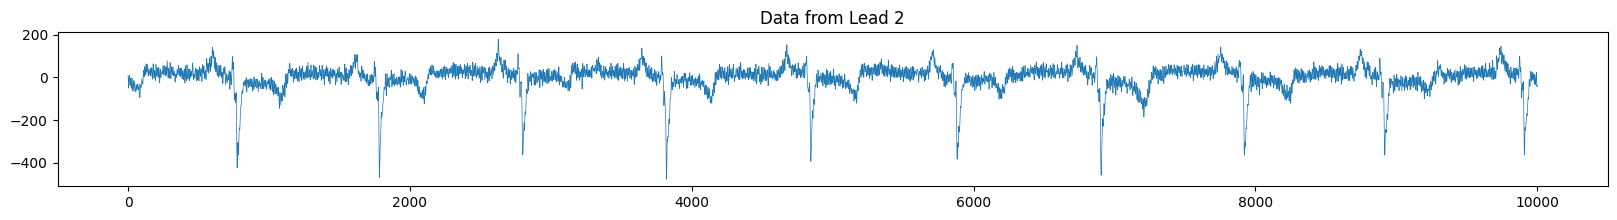

In [5]:
plotSignal(getLeadData(2), "Data from Lead 2")

Step 3: Setting up a way to implement filters

Filters will be described by their LCCDE coefficients and the output will be determined in the same way

In [6]:
class filter:
    def __init__(self, windowSize):
        self.windowSize = windowSize
        #By default, initialise a zero filter
        self.xCoeffs = np.zeros(processingDelay)
        self.yCoeffs = np.zeros(processingDelay)
    
    def __init__(self, xCoeffs, yCoeffs):
        self.windowSize = len(xCoeffs)
        self.xCoeffs = np.array(xCoeffs)
        self.yCoeffs = np.array(yCoeffs)

    def apply(self, signal):
        n = len(signal)
        result = np.zeros(n)
        for i in range(n):
            for j in range(self.windowSize):
                if i - j < 0:
                    break
                result[i] -= self.yCoeffs[j]*result[i - j]
                result[i] += self.xCoeffs[j]*signal[i - j]
            result[i] /= self.yCoeffs[0]
        return result
                

The Pan Tomkins filters were created for 200Hz, so we downsample the input data:

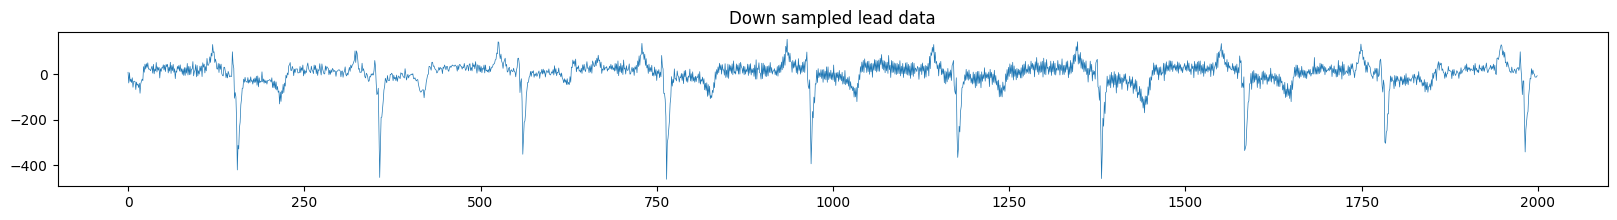

In [7]:
leadData = getLeadData(2)
downsampledData = leadData[0::5].copy()

plotSignal(downsampledData, "Down sampled lead data")

The Pan Tomkins Bandpass filter:

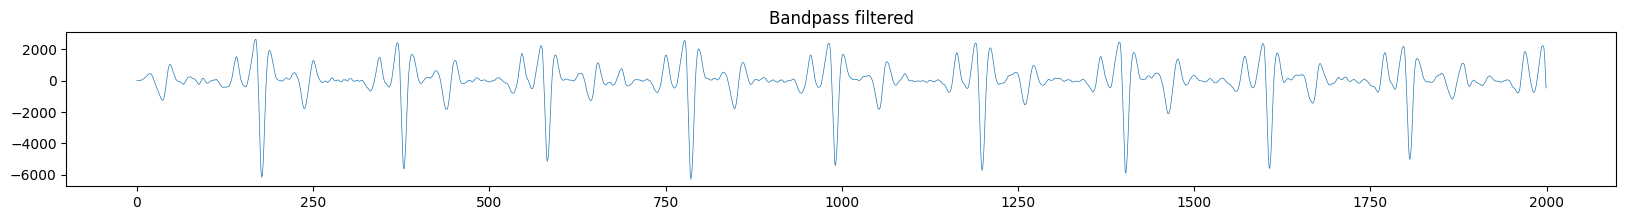

In [8]:
#Pan Tomkins Low Pass filter
xCoeffs = [1,0,0,0,0,0,-2,0,0,0,0,0,1]
yCoeffs = [1,-2,1,0,0,0,0,0,0,0,0,0,0]
PanTomkinsLowPass = filter(xCoeffs, yCoeffs)

#Pan Tomkins High Pass filter
xCoeffs = np.zeros(33)
xCoeffs[0] = -1/32
xCoeffs[16] = 1
xCoeffs[17] = -1
xCoeffs[32] = 1/32
yCoeffs = np.zeros(33)
yCoeffs[0] = 1
yCoeffs[1] = -1
PanTomkinsHighPass = filter(xCoeffs, yCoeffs)

lowPassedSignal = PanTomkinsLowPass.apply(downsampledData)
bandPassedSignal = PanTomkinsHighPass.apply(lowPassedSignal)

plotSignal(bandPassedSignal, "Bandpass filtered")

The Pan Tomkins Derivative filter: (slightly modified to be causal by introducing a delay)

In [9]:
yCoeffs = [10, 0, 0, 0, 0]
xCoeffs = [1, 2, 0, -2, -1]
PanTomkinsDerivative = filter(xCoeffs, yCoeffs)

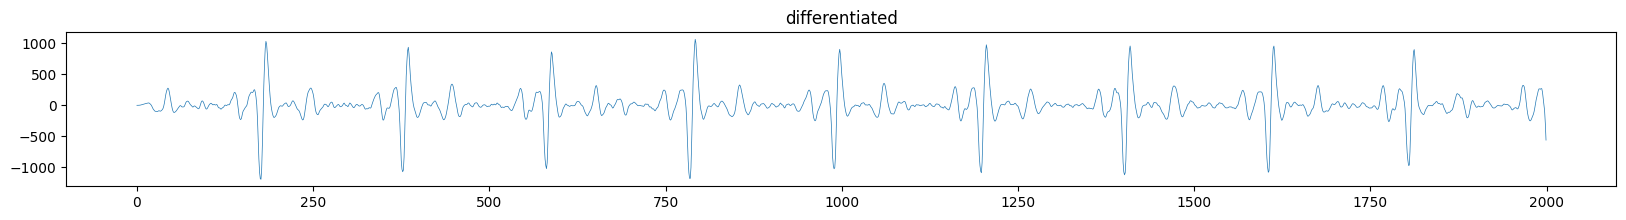

In [10]:
#The next step in Pan Tomkins processing: derivative filter and square:
differentiatedSignal = PanTomkinsDerivative.apply(bandPassedSignal)
plotSignal(differentiatedSignal, "differentiated")

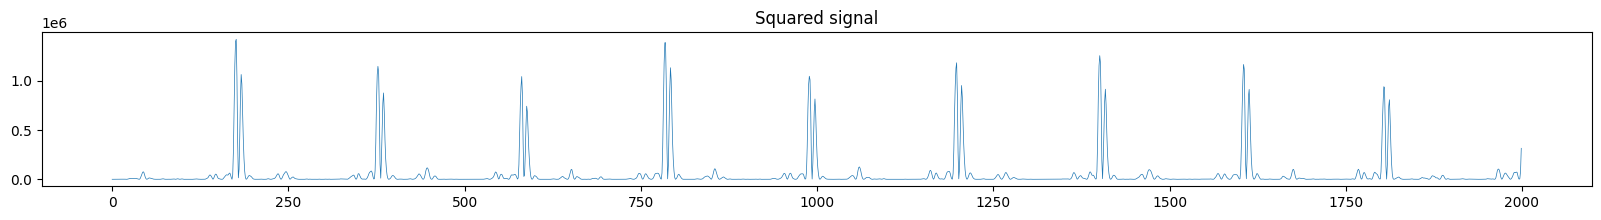

In [11]:
def square(num):
    return num**2
squareOp = np.vectorize(square)
squaredSignal = squareOp(differentiatedSignal)

plotSignal(squaredSignal, "Squared signal")

The next step is running a moving average on a window of size 150ms (30 samples at 200Hz)

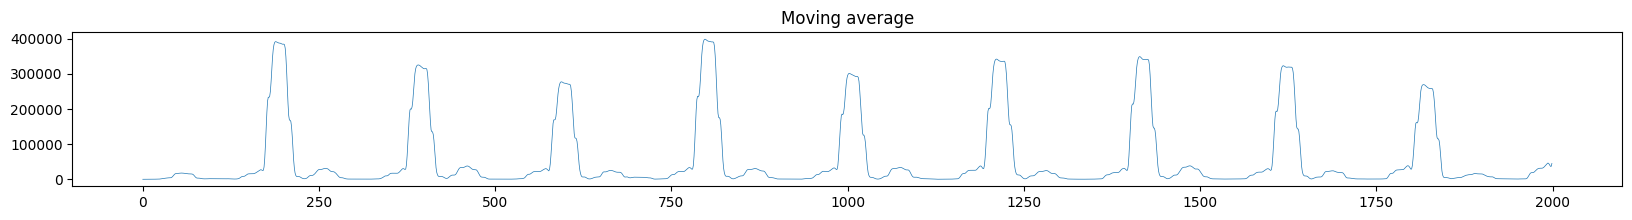

In [12]:
xCoeffs = np.ones(30)/30
yCoeffs = np.zeros(30)
yCoeffs[0] = 1
WindowAverageFilter = filter(xCoeffs, yCoeffs)

windowIntegratedSignal = WindowAverageFilter.apply(squaredSignal)
plotSignal(windowIntegratedSignal, "Moving average")

Approach 1 at peak detection by simply checking if greater than both neighbors (not great results)

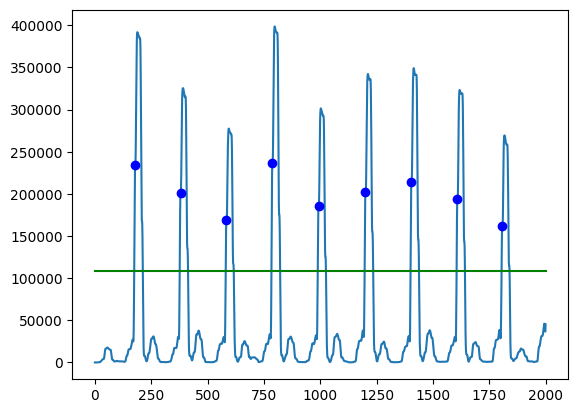

In [13]:
#Simple thresholding: 2 times the mean
threshold = 2*sum(windowIntegratedSignal)/len(windowIntegratedSignal)

#Approach 1 at peak finding
peaks = []
nextFilterActivation = 0
lockoutTime = 40 #200 ms at 200 Hz
for i in range(1, len(windowIntegratedSignal)-1):
    if i < nextFilterActivation:
        continue
    if windowIntegratedSignal[i] < threshold:
        continue
    if windowIntegratedSignal[i] > max(windowIntegratedSignal[i+1], windowIntegratedSignal[i-1]):
        peaks.append(i)
        nextFilterActivation = i + lockoutTime

plt.plot(windowIntegratedSignal)
y = np.empty(len(peaks))
for i in range(len(peaks)):
    peak = peaks[i]
    y[i] = windowIntegratedSignal[peak]
plt.plot(peaks, y, 'bo')
plt.plot([0, 2000], [threshold, threshold], color='green')

Approach 2 at peak finding by finding maximum of values over the threshold

[188, 391, 594, 798, 1002, 1211, 1414, 1618, 1817]


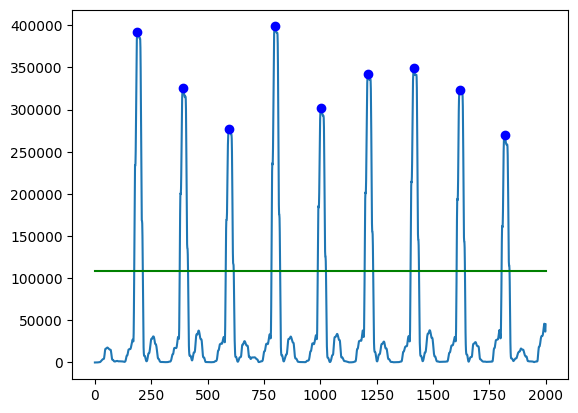

In [14]:
#Approach 2 at peak finding:

threshold = 2*sum(windowIntegratedSignal)/len(windowIntegratedSignal)
peakDetection = False
currentPeakIdx = 0
peaks = []
for i in range(len(windowIntegratedSignal)):
    datapoint = windowIntegratedSignal[i]
    if datapoint < threshold and peakDetection == True:
        peakDetection = False
        peaks.append(currentPeakIdx)
        currentPeakIdx = 0
    elif datapoint > threshold:
        peakDetection = True
        if datapoint > windowIntegratedSignal[currentPeakIdx]:
            currentPeakIdx = i

print(peaks)

plt.plot(windowIntegratedSignal)
y = np.empty(len(peaks))
for i in range(len(peaks)):
    peak = peaks[i]
    y[i] = windowIntegratedSignal[peak]
plt.plot(peaks, y, 'bo')
plt.plot([0, 2000], [threshold, threshold], color='green')


In [15]:
#generalised:

def findPeaks(signal):
    threshold = sum(signal)/len(signal)
    peakDetection = False
    currentPeakIdx = 0
    peaks = []
    for i in range(len(signal)):
        datapoint = signal[i]
        if datapoint < threshold and peakDetection == True:
            peakDetection = False
            peaks.append(currentPeakIdx)
            currentPeakIdx = 0
        elif datapoint > threshold:
            peakDetection = True
            if datapoint > signal[currentPeakIdx]:
                currentPeakIdx = i
    return peaks


The processing delays for each of the filters:
- Lowpass: 2
- Highpass: 16
- Differential: 2
- Moving window: 15

So we need to compensate the output by 35 samples.

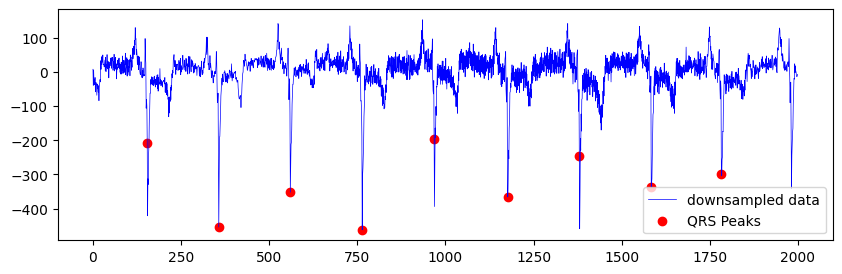

In [16]:
def addCompensation(num):
    return num - 34
compensateDelay = np.vectorize(addCompensation)

qrsLocations = compensateDelay(np.array(peaks))
qrsPlotYData = np.array([downsampledData[loc] for loc in qrsLocations])

plt.figure(figsize=(10, 3))
plt.plot(downsampledData, linewidth=0.5, color='blue', label="downsampled data")
plt.scatter(qrsLocations, qrsPlotYData, color='red', marker='o', label="QRS Peaks")
plt.legend()
plt.show()

Approach without downsampling

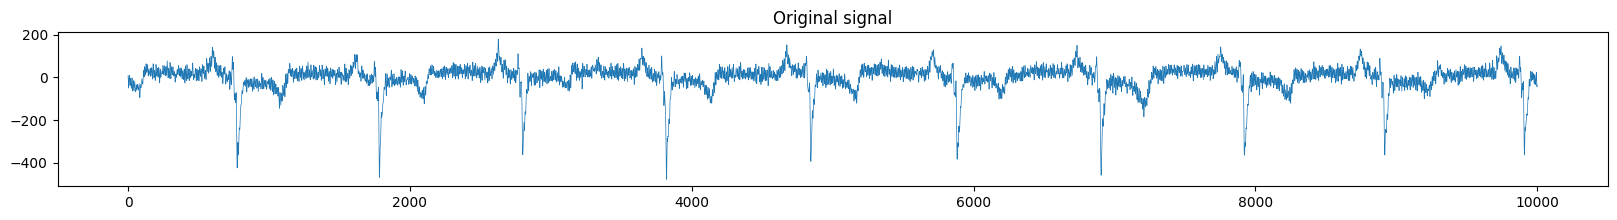

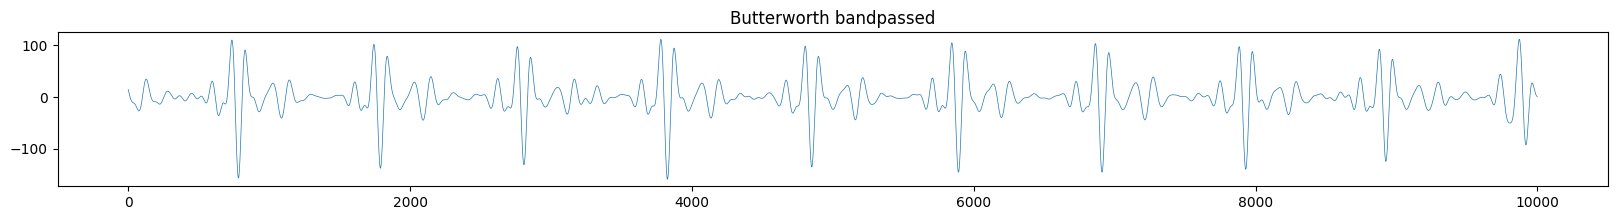

9999


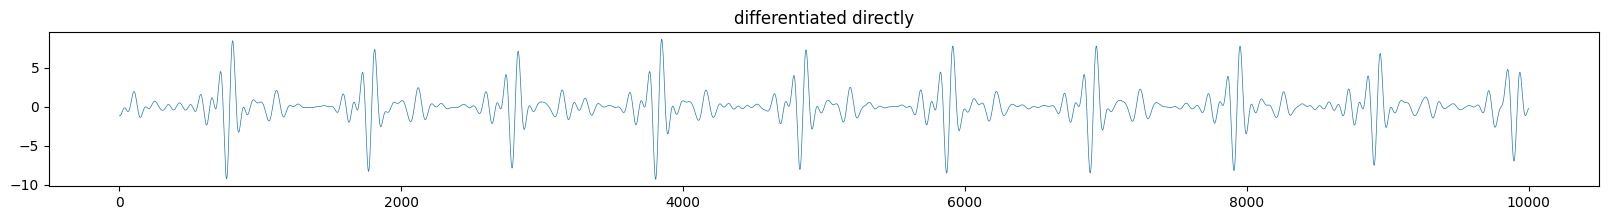

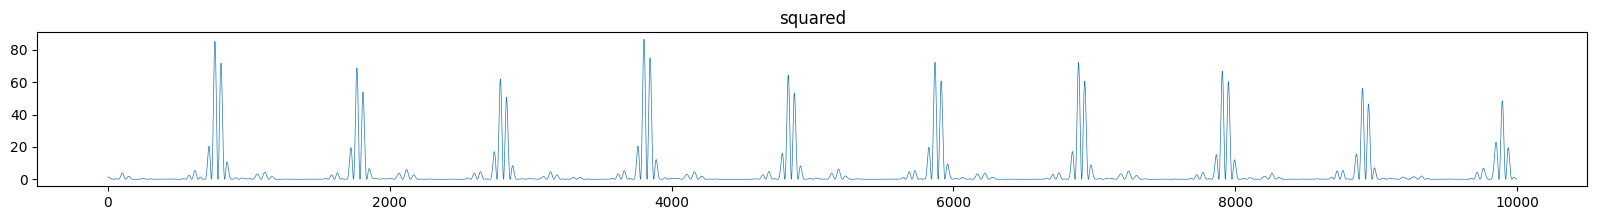

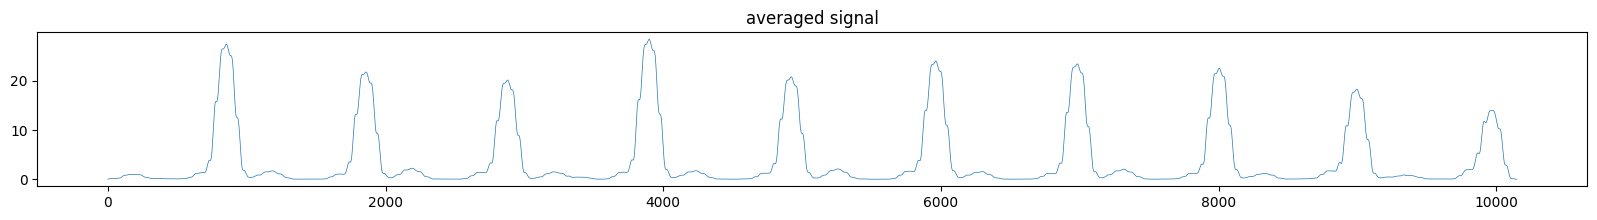

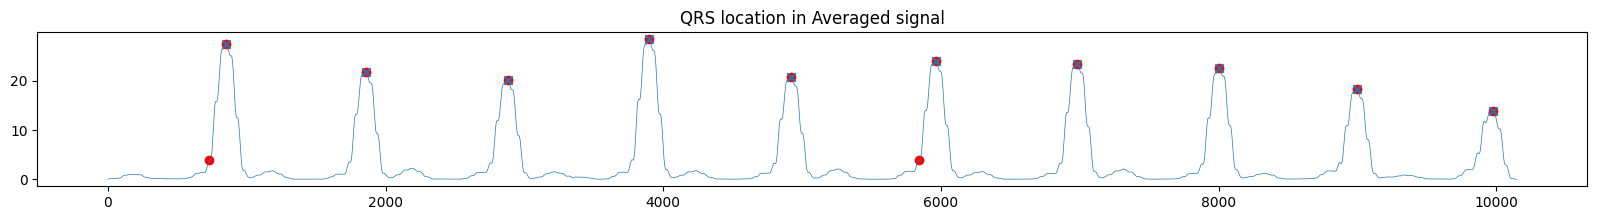

In [28]:
inpSignal = getLeadData(2)
plotSignal(inpSignal, "Original signal")

w1 = 1/100 #5Hz, normalised by sample rate
w2 = 3/100 #15Hz, normalised by sample rate
b, a = sig.butter(4, [w1, w2], 'bandpass')
bandpassedSignal = sig.filtfilt(b, a, inpSignal)
plotSignal(bandpassedSignal, "Butterworth bandpassed")

diffSignal2 = np.diff(bandpassedSignal)
print(len(diffSignal2))
plotSignal(diffSignal2, "differentiated directly")

squaredSignal = np.power(diffSignal2, 2)
plotSignal(squaredSignal, "squared")

windowLength = 150
movingWindowAverage = np.ones(windowLength)/windowLength
averagedSignal = np.convolve(squaredSignal, movingWindowAverage)
plotSignal(averagedSignal, "averaged signal")

qrsLocations = findPeaks(averagedSignal)
qrsLocations2 = sig.find_peaks(averagedSignal, height=np.mean(averagedSignal), distance = 200)
qrsYData = [averagedSignal[loc] for loc in qrsLocations]
plt.figure(figsize=(20, 2))
plt.plot(averagedSignal, linewidth=0.5)
plt.scatter(qrsLocations, qrsYData, marker='o', color='red')
plt.scatter(qrsLocations2[0], qrsLocations2[1]['peak_heights'], marker='x')
plt.title("QRS location in Averaged signal")
plt.show()

# Potential improvement:
- Use dispersion based peak detection to capture qrs onset properly
- Filter out low power regions to reduce noise
- FFT the ECG and see if we can pull anything out from there

# Dispersion based peak detection:
Detects entire regions as peaks rather than just individual points. We can use the rising edge of these peaks to detect QRS waves

Algorithm source: https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data/22640362#22640362

In [43]:
def findPeaksViaDispersion(signal):
    #Initialising parameters
    lag = 300
    stdDevThreshold = 3
    influence = 0
    minThreshold = 2*np.mean(signal)

    #Initialise variables
    result = np.zeros(len(signal))
    filteredY = signal[:lag]
    filteredY = np.append(filteredY, np.zeros(len(signal) - lag))
    avg = np.mean(filteredY[:lag])
    stdDev = np.std(filteredY[:lag])
    avgArr = np.zeros(len(signal))
    thresholdArr = np.zeros(len(signal))
    avgArr[lag-1] = avg
    thresholdArr[lag-1] = max(stdDev, minThreshold)
    totalAvg = np.mean(signal)

    for i in range(lag, len(signal)):
        if signal[i] - avg > max(stdDevThreshold*stdDev, minThreshold) and signal[i] > totalAvg:
            result[i] = 1
            filteredY[i] = influence*signal[i] + (1 - influence)*avg
        else:
            result[i] = 0
            filteredY[i] = signal[i]
        avg = np.mean(filteredY[i-lag+1 : i + 1])
        stdDev = np.std(filteredY[i-lag+1 : i + 1])
        avgArr[i] = avg
        thresholdArr[i] = max(stdDev*stdDevThreshold, minThreshold)
    return result, avgArr, thresholdArr

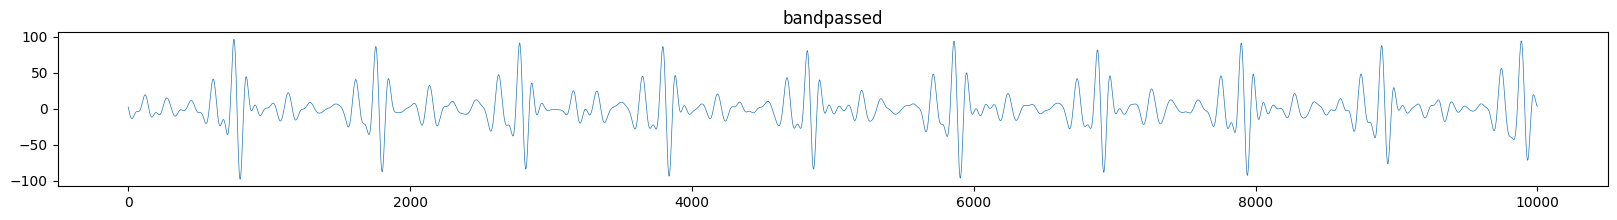

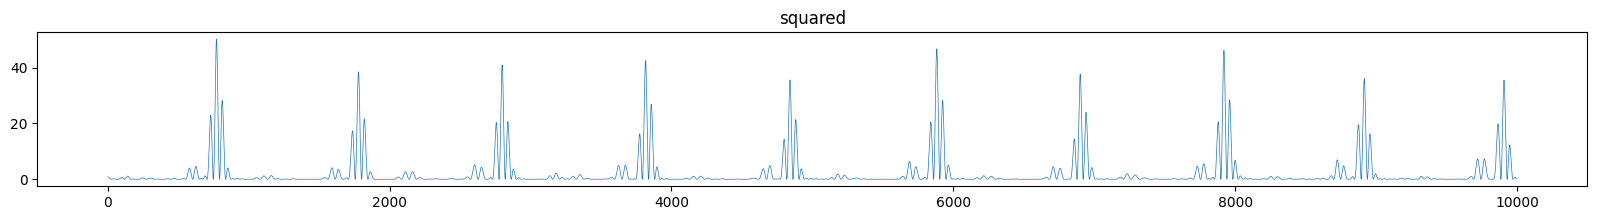

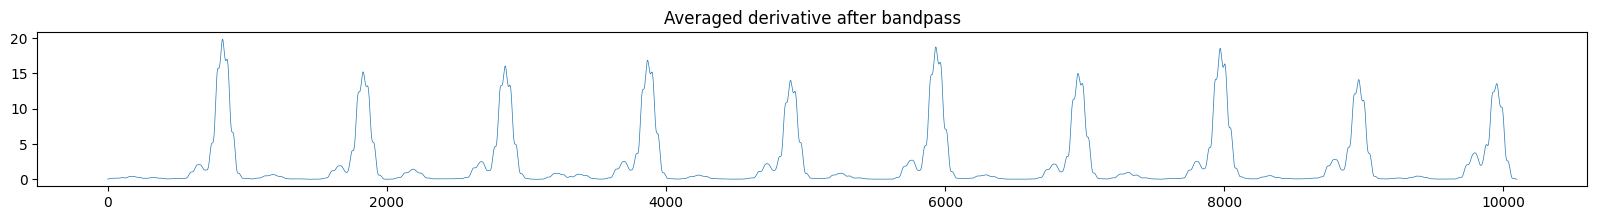

In [40]:
#Preliminary signal processing
inpSignal = getLeadData(5)
w1 = 1/100 #5Hz, normalised by sample rate
w2 = 3/100 #15Hz, normalised by sample rate
b, a = sig.butter(4, [w1, w2], 'bandpass')
bandpassedSignal = sig.filtfilt(b, a, inpSignal)
plotSignal(bandpassedSignal, "bandpassed")
diffSignal = np.diff(bandpassedSignal)
squaredSignal = np.power(diffSignal, 2)
plotSignal(squaredSignal, "squared")
windowLength = 100
movingWindowAverage = np.ones(windowLength)/windowLength
averagedSignal = np.convolve(squaredSignal, movingWindowAverage)
plotSignal(averagedSignal, "Averaged derivative after bandpass")

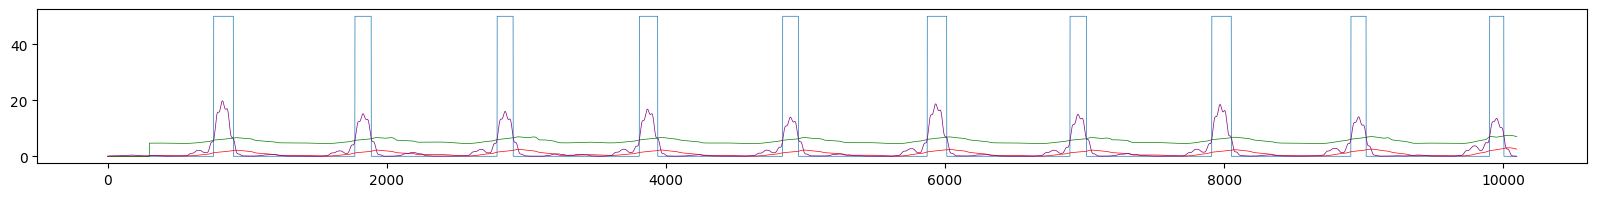

[0. 0. 0. ... 0. 0. 0.]


In [44]:
peakSignal, avgSignal, stdSignal = findPeaksViaDispersion(averagedSignal)
#plotSignal(peakSignal, "Peak detection on the averaged signal")
plt.figure(figsize=(20, 2))
plt.plot(50*peakSignal, linewidth=0.5)
plt.plot(avgSignal, linewidth=0.5, color='red')
plt.plot(avgSignal+stdSignal, linewidth=0.5, color='green')
plt.plot(averagedSignal, linewidth=0.5, color='purple')
plt.show()
print(peakSignal)

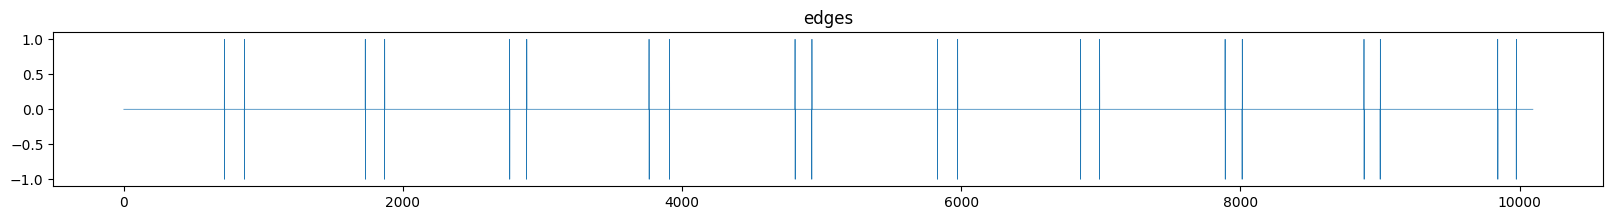

In [23]:
#Extracting rising edges from the peak signal
edges = np.diff(peakSignal)
#Optional: Compensate for the convolution window width to calculatee actual QRS width
#(seems to give worse results)
for i in range(len(edges)):
    if edges[i] == -1:
        if i >= 100:
            edges[i-50] = -1
        edges[i] = 0
#Make peaks both positive and negative
edges = np.diff(edges)
plotSignal(edges, "edges")

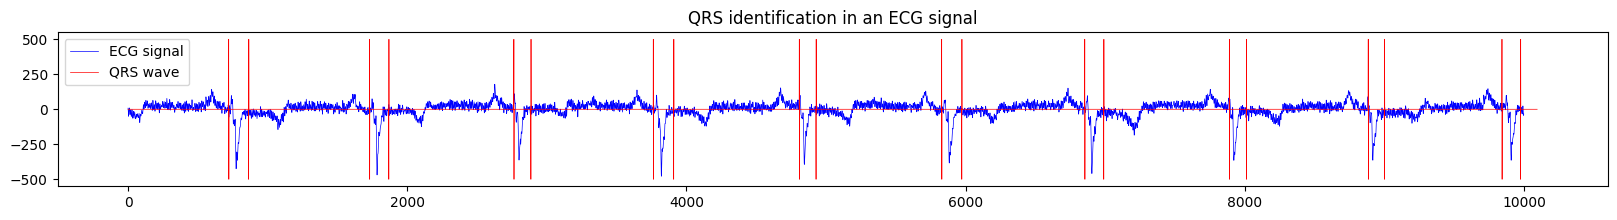

In [24]:
plt.figure(figsize=(20, 2))
plt.plot(inpSignal, linewidth=0.5, color='blue', label='ECG signal')
plt.plot(500*edges, linewidth=0.5, color='red', linestyle='-', label='QRS wave')
plt.legend()
plt.title("QRS identification in an ECG signal")
plt.show()

In [31]:
#Generalsing:

def detectQRS(ecgLeadData):
    inpSignal = ecgLeadData
    w1 = 1/100 #5Hz, normalised by sample rate
    w2 = 3/100 #15Hz, normalised by sample rate
    b, a = sig.butter(4, [w1, w2], 'bandpass')
    bandpassedSignal = sig.filtfilt(b, a, inpSignal)
    diffSignal = np.diff(bandpassedSignal)
    squaredSignal = np.power(diffSignal, 2)
    windowLength = 100
    movingWindowAverage = np.ones(windowLength)/windowLength
    averagedSignal = np.convolve(squaredSignal, movingWindowAverage)
    peakSignal, _, _ = findPeaksViaDispersion(averagedSignal)
    edges = np.diff(peakSignal)
    edges = np.diff(edges)
    x = np.argwhere(edges).flatten()
    #Compensate for the 50 sample delay introduced by convolution while plotting
    mult = max(abs(np.max(ecgLeadData)), abs(np.min(ecgLeadData)))
    plt.figure(figsize=(20, 2))
    plt.plot(ecgLeadData, linewidth=0.5, color='blue', label='ECG signal')
    plt.plot(mult*edges[50:], linewidth=0.5, color='red', label='QRS wave')
    plt.legend()
    plt.title("QRS identification in an ECG signal")
    plt.show()

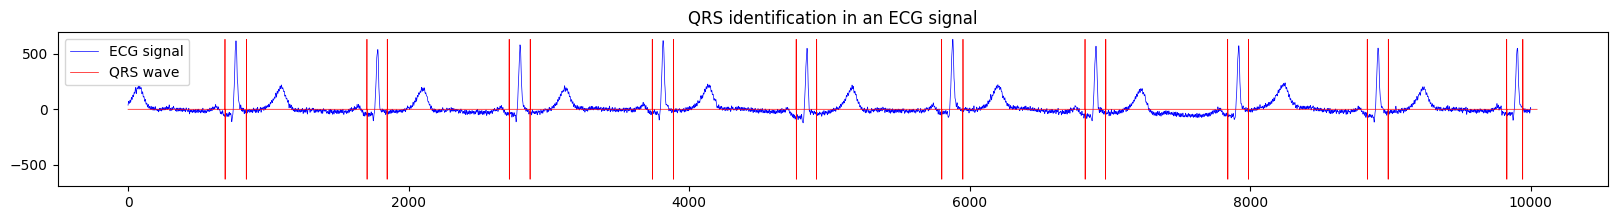

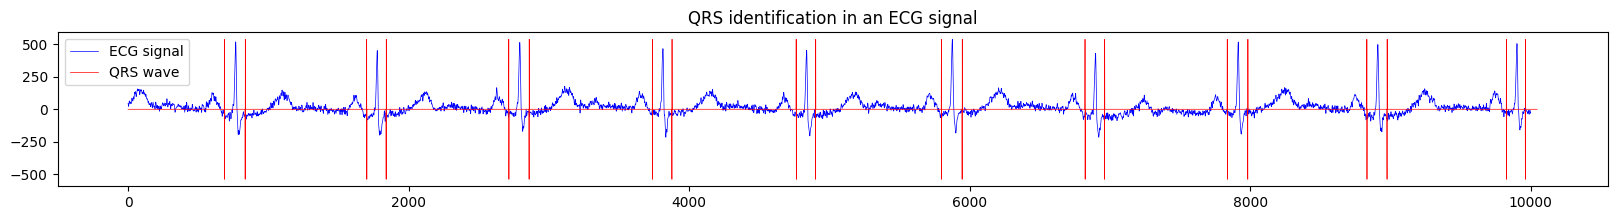

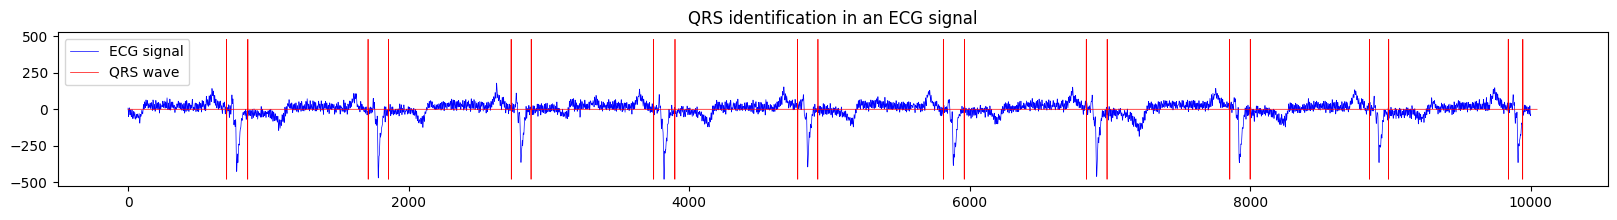

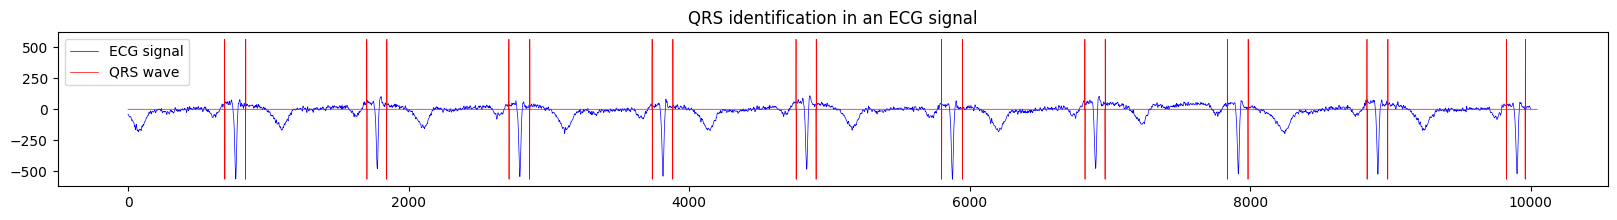

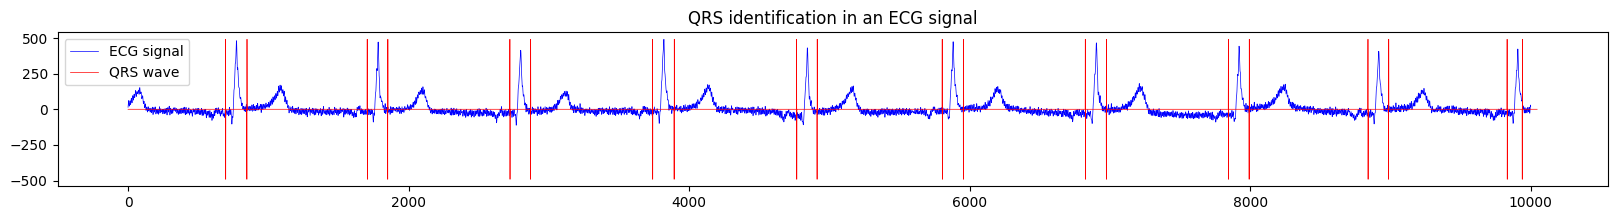

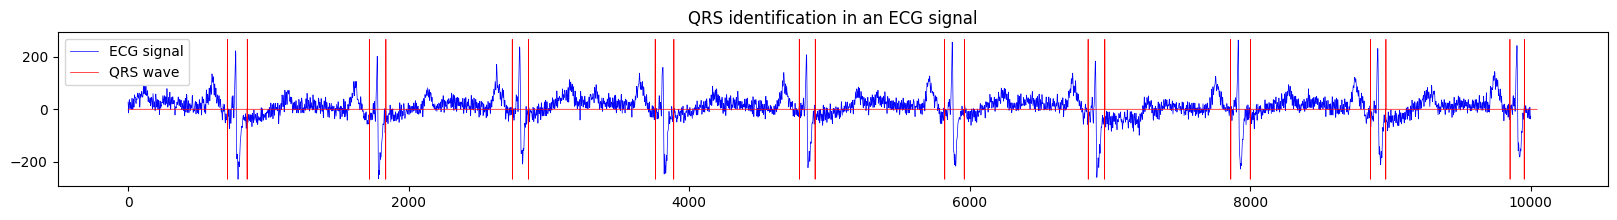

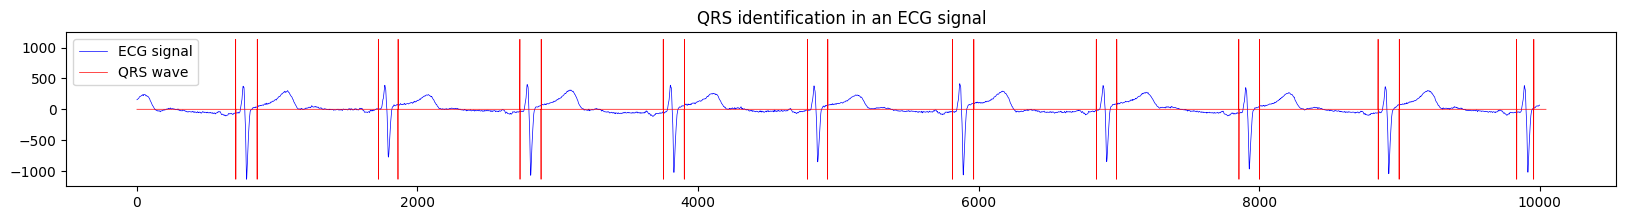

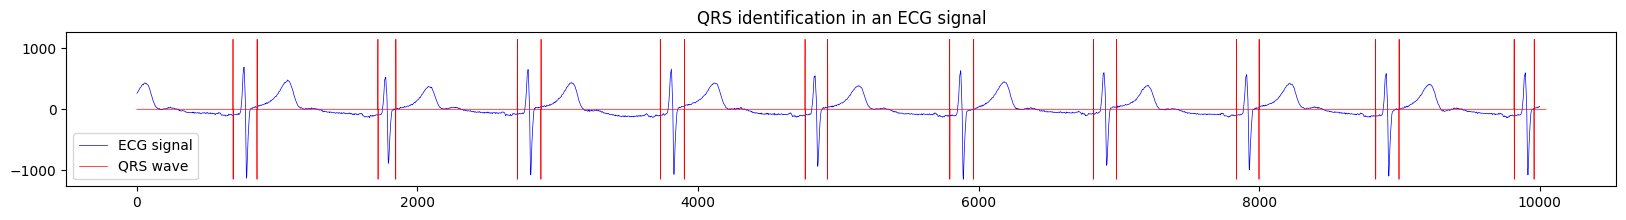

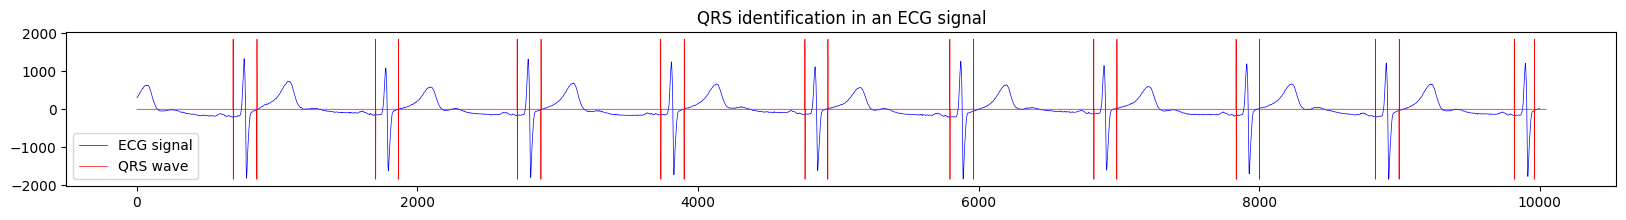

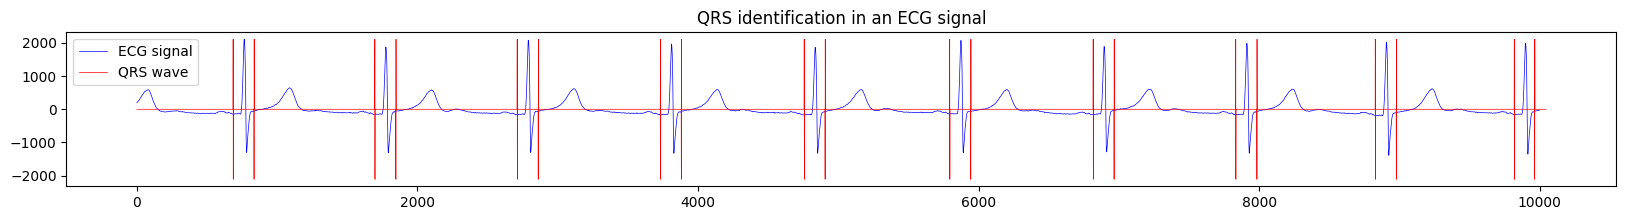

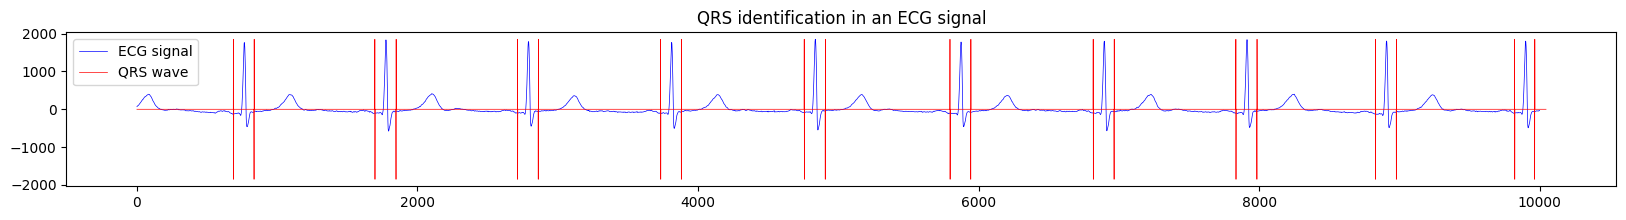

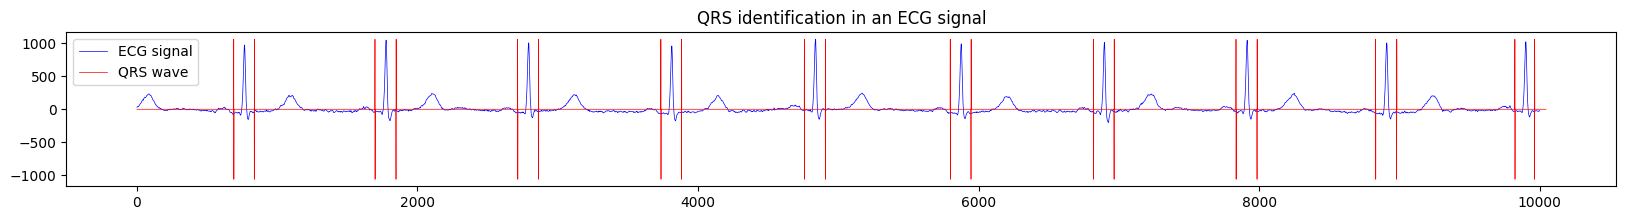

In [46]:
for i in range(12):
    detectQRS(getLeadData(i))

/home/abhi/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


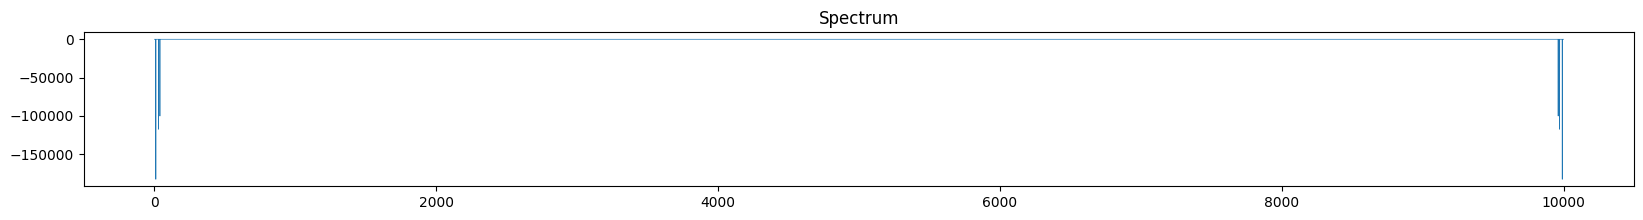

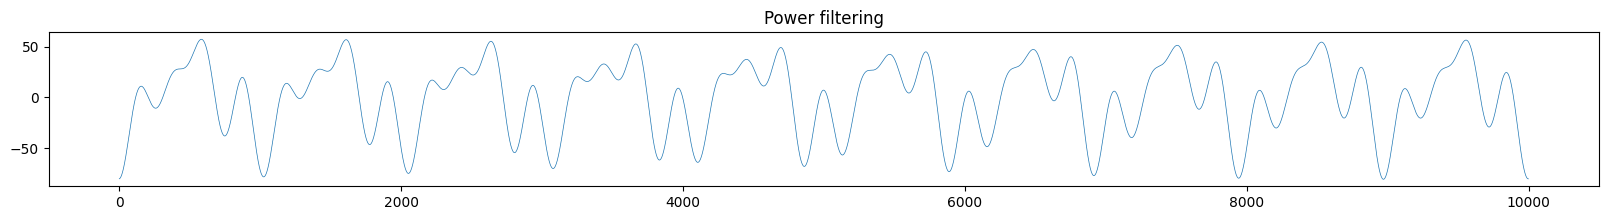

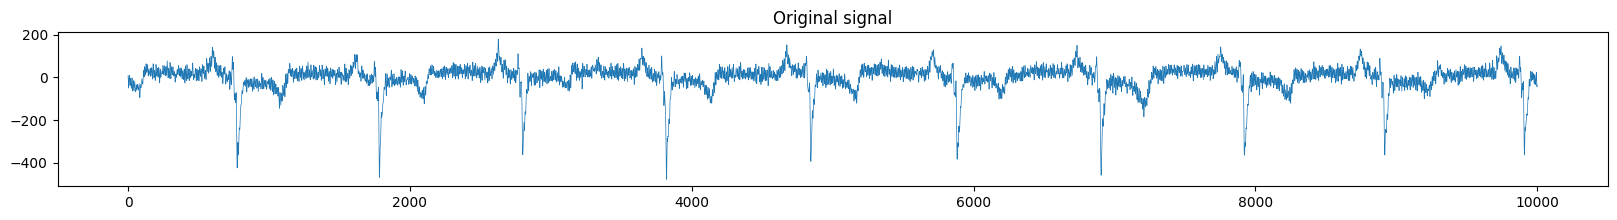

In [27]:
inpSignal = getLeadData(2)
spectrum = np.fft.fft(inpSignal)
for i in range(len(spectrum)):
    if abs(spectrum[i]) < 100000:
        spectrum[i] = 0
filteredSignal = np.fft.ifft(spectrum)
plotSignal(spectrum, "Spectrum")
plotSignal(filteredSignal, "Power filtering")
plotSignal(inpSignal, "Original signal")